# **DSCI 100 Team 11 Project Report: Classifying students' knowledge level of Electrical DC Machines based on the relationship between PEG and LPR**

## Introduction

An Electrical Direct Current (DC) Machine can be classified as a DC motor or a DC generator, and it is responsible for altering electromechanical energy depending on the type of machine it is. For example, a DC motor will convert DC electrical power to mechanical power, while a DC generator will do the opposite. DC machines are used in trains, mills, and mines. 

By method of K-nearest neighbours classification (KNN), using a dataset about students' knowledge on the subject of Electrical DC Machines, we will answer the question of how the knowledge level on Electrical DC Machines of a user is classified based on two predictors: PEG, exam performance of the user for goal objects (knowledge on Electrical DC Machines), and LPR, exam performance of the user for related objects (knowledge on subjects related to Electrical DC Machines) with the goal object.

This dataset is a csv file that has been split into a training and testing dataset. There are 5 predictors: STG ( degree of study time for goal object materials), SCG (degree of repetition number of user for goal object materials), STR (degree of study time of user for related objects with goal object), LPR, and PEG, and one response variable, UNS (knowledge level on Electrical DC Machines of the user), which includes 4 different categories: “Very Low”, “Low”, “Middle”, and “High”.

## Methods and Results

Reading our dataset into R.

In [13]:
# Loading test and training sets into separate dataframes (they have already been separated by the dataset authors)

# install.packages("themis")

library(tidyverse)
library(readxl)
library(repr)
library(tidymodels)
library(themis)

train_url <- 'https://raw.githubusercontent.com/miketham24/team-11-dsci-100-project/main/data/Data_User_Modeling_Dataset_Hamdi-Tolga-KAHRAMAN_training.csv'
train_path <- 'data/user_knowledge_train.csv'
download.file(train_url, train_path)
uk_train <- read_csv(train_path) |>
    select(-...7, -...8, -'Attribute Information:') # this will be our training data

test_url <- 'https://raw.githubusercontent.com/miketham24/team-11-dsci-100-project/main/data/Data_User_Modeling_Dataset_Hamdi-Tolga-KAHRAMAN_testing.csv'
test_path <- 'data/user_knowledge_test.csv'
download.file(test_url, test_path)
uk_test <- read_csv(test_path) |>
    select(-...7, -...8, -'Attribute Information:') # and this will be our testing data

head(uk_train)
head(uk_test)

New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...7`
• `` -> `...8`
Rows: 145 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


Our data is already mostly tidied: each of the cell values occurs only once, each vector represents one variable, and each row one observation. All numerical vectors are `<dbl>`.

In [14]:
# There are still a few things we can do to tidy our data

uk_train_scaled <- uk_train |>
    mutate(UNS = as_factor(UNS)) |>   # Here we convert USN from <chr> to <fct>
    mutate(UNS = fct_recode(UNS, "Very Low" = "very_low")) |>   # Now we standardize UNS class names between testing and training sets
    mutate(STG = scale(STG),   # And finally scale and centre our numerical data
           SCG = scale(SCG),
           STR = scale(STR),
           LPR = scale(LPR),
           PEG = scale(PEG))

uk_test_scaled <- uk_test |>
    mutate(UNS = as_factor(UNS)) |>   # We also want to convert UNS to <fct> with our testing data
    mutate(STG = scale(STG),   # As well as centre and scale the test numerical data
           SCG = scale(SCG),
           STR = scale(STR),
           LPR = scale(LPR),
           PEG = scale(PEG))

head(uk_train_scaled)
head(uk_test_scaled)

STG,SCG,STR,LPR,PEG,UNS
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
-1.765089,-1.6780077,-1.9029207,-1.7440515,-1.7967053,Very Low
-1.384627,-1.3005822,-1.4963171,-0.7767309,1.7297900,High
-1.479743,-1.3949386,-1.6996189,-0.7364259,-0.5036570,Low
-1.289512,-1.2062258,-1.2930153,0.8757751,-0.6212069,Middle
-1.384627,-1.3005822,-1.5776378,2.2058409,-0.8563066,Low
-1.337070,-0.9703348,-0.2765062,-1.3410013,0.7893912,Middle


STG,SCG,STR,LPR,PEG,UNS
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
-1.5142778,-1.1525157,0.2452099,-0.6155307,-1.4020025,Very Low
-1.2784849,-1.3772532,0.4470002,0.6235230,-1.0884978,Low
-1.1370092,-0.7929358,0.7698645,0.6235230,1.3847057,High
-0.5711065,-0.7030408,0.9716548,0.8786222,1.3847057,High
-0.4767893,-0.6131458,1.8595318,-0.4697597,1.5588750,High
-0.8540579,-0.9727257,1.0523709,0.2590954,-0.5311562,Low


Creating training data summary statistic tables.

In [15]:
# table_1 counts the number of observations in each UNS class
table_1 <- uk_train_scaled |>
    group_by(UNS) |>
    count() |>
    rename(count = n)
table_1

# table_2 gives us the minimum, maximum and mean of each numerical variable
table_2 <- uk_train_scaled |>
    summarize(across(where(is.numeric), .fns =
                     list(minimum = min,
                          maximum = max,
                          mean = mean))) |>
    pivot_longer(cols = everything(),
               names_sep = '_',
               names_to = c('.value', 'variable'))
table_2

UNS,count
<fct>,<int>
Very Low,24
High,63
Low,83
Middle,88


variable,STG,SCG,STR,LPR,PEG
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
minimum,-1.765089e+00,-1.678008e+00,-1.902921e+00,-1.744052e+00,-1.796705e+00
maximum,2.943117e+00,2.568030e+00,1.959814e+00,2.246146e+00,1.847340e+00
mean,-8.605035e-17,5.559184e-17,7.350975e-17,1.052412e-16,6.393977e-17


Making some scatterplots to determine what variables are most viable as predictors for `UNS`.

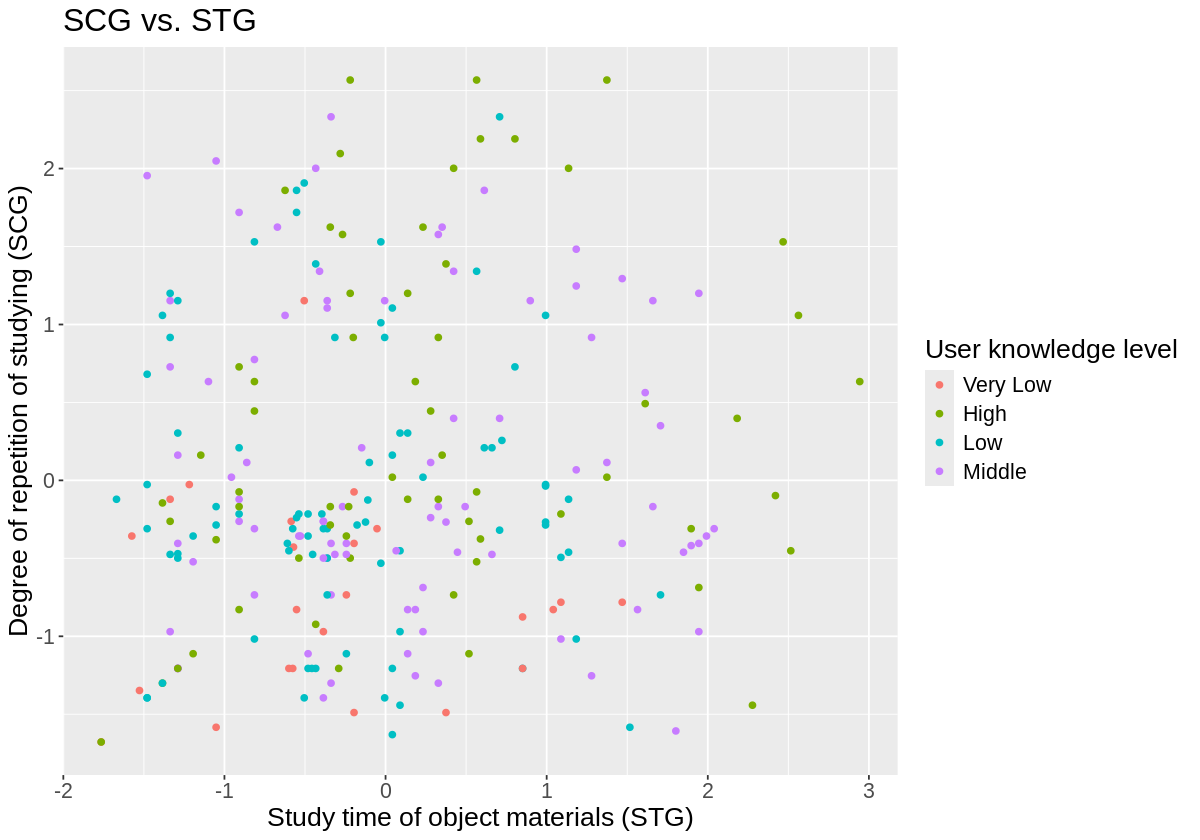

In [16]:
# scatterplot visualizing relationships of SCG, STG and UNS in the scaled training data

options(repr.plot.height = 7, repr.plot.width = 10)

ggplot(uk_train_scaled,
       aes(x = STG,
           y = SCG,
           colour = UNS)) +
    geom_point() +
    labs(x = 'Study time of object materials (STG)',
         y = 'Degree of repetition of studying (SCG)',
         colour = 'User knowledge level',
         title = 'SCG vs. STG') +
    theme(text = element_text(size = 16))

There are no obvious patterns of user knowledge level with either `SCG` or `STG`.Trying different variables:

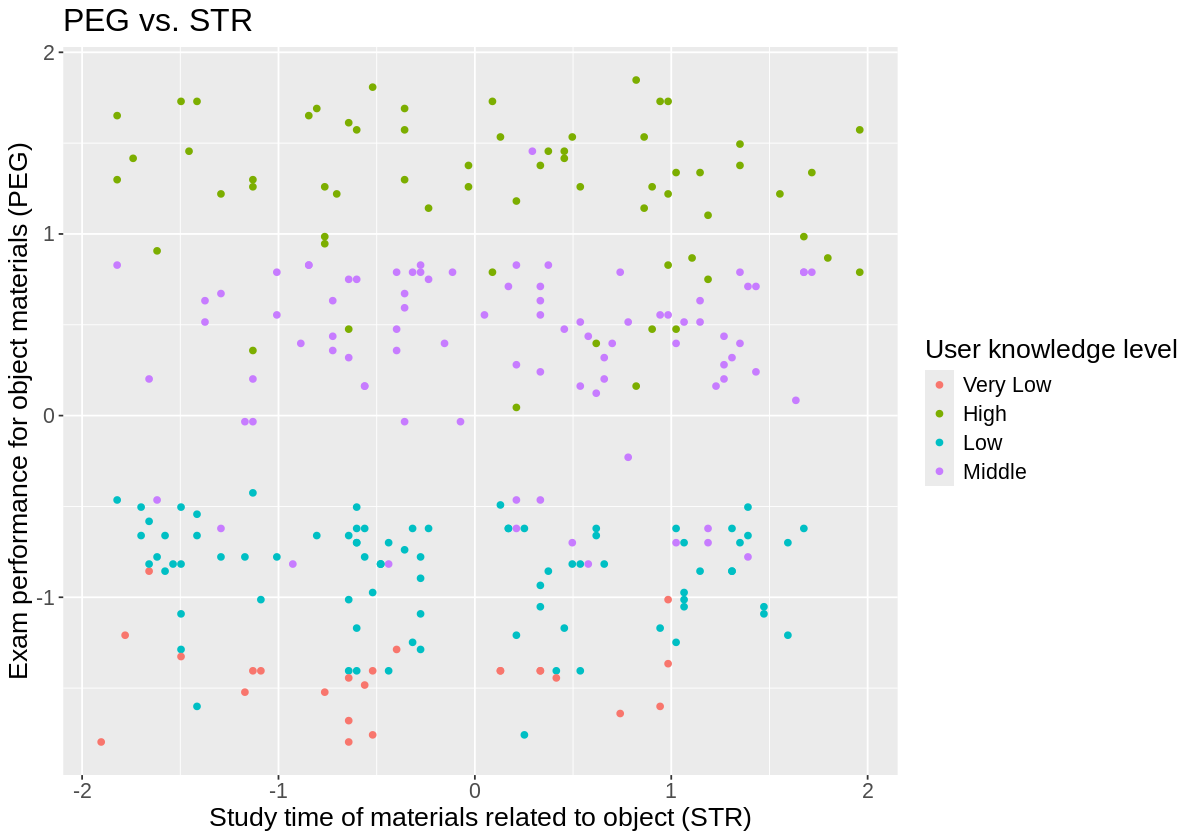

In [17]:
# scatterplot visualizing relationships of PEG, STR and UNS in the scaled training data

options(repr.plot.height = 7, repr.plot.width = 10)

ggplot(uk_train_scaled,
       aes(x = STR,
           y = PEG,
           colour = UNS)) +
    geom_point() +
    labs(x = 'Study time of materials related to object (STR)',
         y = 'Exam performance for object materials (PEG)',
         colour = 'User knowledge level',
         title = 'PEG vs. STR') +
    theme(text = element_text(size = 16))

Here we see a clear positive relationship between `UNS` and `PEG`. However, it doesn't seem to have any relation to `STR`, so it's best if we find a different second predictor.

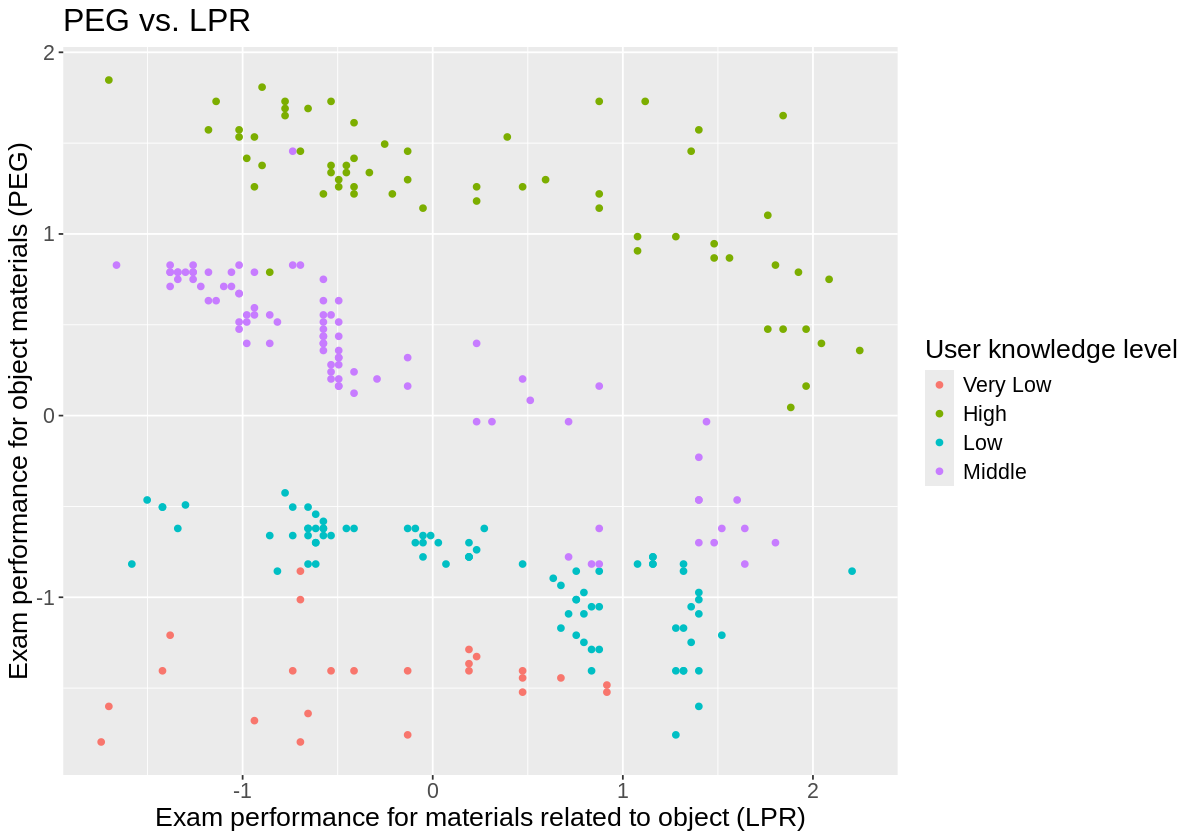

In [18]:
# scatterplot visualizing relationships of PEG, LPR and UNS in the scaled training data

options(repr.plot.height = 7, repr.plot.width = 10)

ggplot(uk_train_scaled,
       aes(x = LPR,
           y = PEG,
           colour = UNS)) +
    geom_point() +
    labs(x = 'Exam performance for materials related to object (LPR)',
         y = 'Exam performance for object materials (PEG)',
         colour = 'User knowledge level',
         title = 'PEG vs. LPR') +
    theme(text = element_text(size = 16))

This scatterplot demonstrates a stronger relationship between both axis variables and user knowledge level. So, we will be able to build a more accurate k-nearest neighbours model using PEG and LPR as predictors. We can now finish tidying our data by selecting only PEG, LPR and USN in both datasets.

In [19]:
uk_train_scaled <- uk_train_scaled |>
    select(LPR, PEG, UNS)

uk_test_scaled <- uk_test_scaled |>
    select(LPR, PEG, UNS)

head(uk_train_scaled)
head(uk_test_scaled)

LPR,PEG,UNS
"<dbl[,1]>","<dbl[,1]>",<fct>
-1.7440515,-1.7967053,Very Low
-0.7767309,1.7297900,High
-0.7364259,-0.5036570,Low
0.8757751,-0.6212069,Middle
2.2058409,-0.8563066,Low
-1.3410013,0.7893912,Middle


LPR,PEG,UNS
"<dbl[,1]>","<dbl[,1]>",<fct>
-0.6155307,-1.4020025,Very Low
0.6235230,-1.0884978,Low
0.6235230,1.3847057,High
0.8786222,1.3847057,High
-0.4697597,1.5588750,High
0.2590954,-0.5311562,Low


In [20]:
# Starting out our K-NN classification alogrithm 

# Since we have read, cleaned our training data, and the dataset has already been split by the author themselves, we will create our K-NN model specification
# But before that, let's just show what the proportions of training and testing data are

uk_proportions_training <- uk_train |>
                        group_by(UNS) |>
                        summarize(n = n()) |>
                        mutate(percent = 100*n/nrow(uk_train_scaled))

uk_proportions_training

uk_proportions_testing <- uk_test |>
                        group_by(UNS) |>
                        summarize(n = n()) |>
                        mutate(percent = 100*n/nrow(uk_test_scaled))
uk_proportions_testing

# Now for our K-NN model specification
uk_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

UNS,n,percent
<chr>,<int>,<dbl>
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527
very_low,24,9.302326


UNS,n,percent
<chr>,<int>,<dbl>
High,39,26.89655
Low,46,31.72414
Middle,34,23.44828
Very Low,26,17.93103


In [56]:
# After creating our model spec, we want to create a recipe in order to standardize and balance our training data 

uk_recipe <- recipe(UNS ~ LPR + PEG, data = uk_train_scaled) |>
  step_upsample(UNS, over_ratio = 1, skip = FALSE) |>
  step_impute_mean(all_predictors()) |>
  prep()

upsampled_uk <- bake(uk_recipe, uk_train_scaled)

upsampled_uk |>
  group_by(UNS) |>
  summarize(n = n())

# since the over_ratio is 1, the count for each UNS should be the same as shown below. Each count is 88 for each UNS.

UNS,n
<fct>,<int>
Very Low,88
High,88
Low,88
Middle,88


In [54]:
# Creating receipe for standardization
uk_recipe_standardize <- recipe(UNS ~ LPR + PEG, data = upsampled_uk) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

In [55]:
# Creating workflow
uk_fit <- workflow() |>
  add_recipe(uk_recipe) |>
  add_model(uk_spec) |>
  fit(data = upsampled_uk)

Warning message:
“tune samples were requested but there were 352 rows in the data. 347 will be used.”


In [49]:
# Now for predicting our labels based on our test set

uk_test_predictions <- predict(uk_fit, uk_test_scaled) |>
  bind_cols(uk_test_scaled)

head(uk_test_predictions)

.pred_class,LPR,PEG,UNS
<fct>,"<dbl[,1]>","<dbl[,1]>",<fct>
Very Low,-0.6155307,-1.4020025,Very Low
Low,0.6235230,-1.0884978,Low
Middle,0.6235230,1.3847057,High
Middle,0.8786222,1.3847057,High
High,-0.4697597,1.5588750,High
Low,0.2590954,-0.5311562,Low


In [53]:
# Evaluate Performance of our model

# accuracy <- uk_test_predictions |>
#         metrics(truth = UNS, estimate = .pred_class) |>
#         filter(.metric == "accuracy") |>
#         select(.estimate) |>
#         pull()

# accuracy

In [ ]:
# Since we have a rough estimate of the accuracy of our model, we will perform a 5-fold cross-validation 

# uk_vfold <- vfold_cv(uk_train_scaled, v = 5, strata = UNS)

# k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# uk_fit_cross <- workflow() |>
#   add_recipe(uk_recipe) |>
#   add_model(uk_spec) |>
#   tune_grid(resamples = uk_vfold, grid = k_vals) |>
#   collect_metrics()

# uk_accuracies <- knn_results |>
#   filter(.metric == "accuracy")

# uk_accuracies

# uk_accuracy_vs_k <- ggplot(uk_accuracies, aes(x = neighbors, y = mean)) +
#   geom_point() +
#   geom_line() +
#   labs(x = "Neighbors", y = "Accuracy Estimate") +
#   theme(text = element_text(size = 12))

# accuracy_vs_k

# uk_best_k <- uk_accuracies |>
#         arrange(desc(mean)) |>
#         head(1) |>
#         pull(neighbors)
# best_k

In [ ]:
# Accounting for over/underfitting

# k_lots <- tibble(neighbors = seq(from = 1, to = 385, by = 10))

# knn_results <- workflow() |>
#   add_recipe(uk_recipe) |>
#   add_model(uk_spec) |>
#   tune_grid(resamples = uk_vfold, grid = k_lots) |>
#   collect_metrics()

# accuracies_lots <- knn_results |>
#   filter(.metric == "accuracy")

# accuracy_vs_k_lots <- ggplot(accuracies_lots, aes(x = neighbors, y = mean)) +
#   geom_point() +
#   geom_line() +
#   labs(x = "Neighbors", y = "Accuracy Estimate") +
#   theme(text = element_text(size = 12))

# accuracy_vs_k_lots

We will classify the UNS as “Very Low”, “Low”, “Middle”, and “High” based on their PEG and LPR. For this classification analysis, we employ the K-nearest neighbours classification algorithm with our 2 predictor variables being PEG and LPR, to predict and classify the categorical variable, UNS.

We can visualize our results through a scatter plot with PEG on the y-axis and LPR on the x-axis. We will add aesthetic mapping by colouring each data point based on their user knowledge level (UNS).

## Discussion

We expect UNS to have a strong, positive, linear relationship between LPR and PEG . The better the performance on the exam, the better will be their overall knowledge of Electrical DC Machines. Analyzing these findings can help to create effective study curricula for electrical DC machines for computer science students. 

Future Questions:
1. To what extent does study time of related subject areas affect the exam performance of our target study area?
2. Does studying related subject areas improve user knowledge of our target study area?

## Bibliography and References

Kahraman,Hamdi, Colak,Ilhami, and Sagiroglu,Seref. (2013). User Knowledge Modeling. UCI Machine Learning Repository. https://doi.org/10.24432/C5231X.
